In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import glam

%load_ext autoreload
%autoreload 2

# Test Case 3: Systematic parameter recovery

Here, we perform a structured and systematic parameter recovery study. We use the original model variant with 4 parameters ($v$, $\gamma$, $\sigma$, $\tau$). For each parameter, we define a range of sensible values and select a `low`, `medium` and `high` value, based on the individual parameter estimates we obtained by hierarchically fitting the GLAM to the data from Krajbich & Rangel (2011) in Thomas, Molter, Krajbich, Heekeren & Mohr (submitted).

We then pick one parameter, one constellation of values of the remaining three parameters (e.g., we pick $v$, and set $\gamma$, $\sigma$ and $\tau$ to their `low` values). Then, for 10 different values of $v$ along its range, we generate a synthetic dataset for a single participant with N=100 trials, random item values and gaze, fit the model and record the generating and estimated parameters. The procedure is repeated for all possible constellation of other parameter values, and other parameters, resulting in 1080 ($10 \times 4 \times 3^3$) simulated and fitted datasets total.

## Define parameter ranges from 2011 estimates

In [2]:
bounds = dict(v=[0.000015, 0.00015],
              gamma=[-1, 1],
              s=[0.004, 0.011],
              tau=[0.1, 1.25])

ranges = {parameter: np.linspace(*bounds[parameter], 10)
          for parameter in ['v', 'gamma', 's', 'tau']}
ranges

{'gamma': array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
         0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ]),
 's': array([ 0.004     ,  0.00477778,  0.00555556,  0.00633333,  0.00711111,
         0.00788889,  0.00866667,  0.00944444,  0.01022222,  0.011     ]),
 'tau': array([ 0.1       ,  0.22777778,  0.35555556,  0.48333333,  0.61111111,
         0.73888889,  0.86666667,  0.99444444,  1.12222222,  1.25      ]),
 'v': array([  1.50000000e-05,   3.00000000e-05,   4.50000000e-05,
          6.00000000e-05,   7.50000000e-05,   9.00000000e-05,
          1.05000000e-04,   1.20000000e-04,   1.35000000e-04,
          1.50000000e-04])}

In [3]:
# Determine low, medium, high values as 10th, 50th and 90th percentile of these ranges
values = {parameter: np.percentile(np.linspace(*bounds[parameter], 100), [10, 50, 90])
          for parameter in ['v', 'gamma', 's', 'tau']}
values

{'gamma': array([ -8.00000000e-01,   5.55111512e-17,   8.00000000e-01]),
 's': array([ 0.0047,  0.0075,  0.0103]),
 'tau': array([ 0.215,  0.675,  1.135]),
 'v': array([  2.85000000e-05,   8.25000000e-05,   1.36500000e-04])}

# Recover a single GLAM

In [6]:
def recover_glam(parameters, n_trials=100, n_items=3, seed=None):

    G = glam.GLAM()

    G.simulate_group(kind='individual',
                     n_individuals=1,
                     n_trials=n_trials, 
                     n_items=n_items,
                     parameters=parameters,
                     error_weight=0,
                     value_range=[1, 10],
                     seed=seed)
    G.make_model('individual', t0_val=0, error_weight=0)
    G.fit(method='NUTS', n_samples=2000, njobs=1)
    
    return G

In [7]:
parameters = dict(v=[ranges['v'][0]],
                  gamma=[values['gamma'][0]],
                  s=[values['s'][0]],
                  tau=[values['tau'][0]],
                  t0=[0])

res = recover_glam(parameters=parameters, seed=1)

Generating single subject models for 1 subjects...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting 1 model(s) using NUTS...
  Fitting model 1 of 1...


Sequential sampling (2 chains in 1 job)
NUTS: [tau_interval__, SNR_interval__, gamma_interval__, v_interval__]
100%|██████████| 2500/2500 [00:20<00:00, 121.05it/s]
The acceptance probability does not match the target. It is 0.887696485916, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898203533327, but should be close to 0.8. Try to increase the number of tuning steps.


/!\ Automatically setting parameter precision...


# Run over multiple parameter sets

In [4]:
parameter_info = {parameter: dict(low=values[parameter][0],
                                  medium=values[parameter][1],
                                  high=values[parameter][2],
                                  variable=ranges[parameter])
                  for parameter in ['v', 'gamma', 's', 'tau']}

In [9]:
def generate_parameter_sets(parameter_info):

    from itertools import product
    
    levels = ['low', 'medium', 'high']
    parameters = ['v', 'gamma', 's', 'tau']
    
    constellations = list(product(levels, levels, levels))

    index = 0
    
    for variable_parameter in parameter_info.keys():
        
        others = [p for p in parameters
                  if p != variable_parameter]
        
        for other_constellation in constellations:

            for variable_value in parameter_info[variable_parameter]['variable']:

                level_set = dict()
                level_set[variable_parameter] = 'variable'
                parameter_set = dict(t0=[0])
                parameter_set[variable_parameter] = [variable_value]

                for o, other in enumerate(others):
                    level_set[other] = other_constellation[o]
                    parameter_set[other] = [parameter_info[other][other_constellation[o]]]
                    
                index += 1
                yield index, level_set, parameter_set

In [10]:
all_generated_inputs = list(generate_parameter_sets(parameter_info=parameter_info))
all_generated_inputs[:2]

[(1,
  {'gamma': 'low', 's': 'low', 'tau': 'low', 'v': 'variable'},
  {'gamma': [-0.80000000000000004],
   's': [0.0047000000000000002],
   't0': [0],
   'tau': [0.21500000000000002],
   'v': [1.5e-05]}),
 (2,
  {'gamma': 'low', 's': 'low', 'tau': 'low', 'v': 'variable'},
  {'gamma': [-0.80000000000000004],
   's': [0.0047000000000000002],
   't0': [0],
   'tau': [0.21500000000000002],
   'v': [2.9999999999999997e-05]})]

In [11]:
def wrap_recover_glam(generated_input):
    
    from pymc3 import summary
    
    index, level_set, parameter_set = generated_input

    # perform actual recovery
    result = recover_glam(parameter_set, n_trials=100, n_items=3, seed=index)
    
    # check for convergence:
    all_converged = summary(res.trace, varnames=['v', 'gamma', 's', 'tau'])['Rhat'].between(0.9, 1.1).all()
    
    # assemble output dataframe row
    output = pd.DataFrame(dict(index=[index],
                               v_level=[level_set['v']],
                               gamma_level=[level_set['gamma']],
                               s_level=[level_set['s']],
                               tau_level=[level_set['tau']],
                               v_gen=parameter_set['v'],
                               gamma_gen=parameter_set['gamma'],
                               s_gen=parameter_set['s'],
                               tau_gen=parameter_set['tau'],
                               v_rec=result.estimates['v'][0],
                               gamma_rec=result.estimates['gamma'][0],
                               s_rec=result.estimates['s'][0],
                               tau_rec=result.estimates['tau'][0],
                               converged=[all_converged]))
    
    return output

In [ ]:
wrap_recover_glam(all_generated_inputs[0])

## Run the recovery in parallel

In [ ]:
from multiprocessing import Pool, n_c

p = Pool(4)

output = p.map(wrap_recover_glam, generate_parameter_sets(parameter_info))

df = pd.concat(output)
df.to_csv('recovery.csv')
df.head()

# Plot results

The above analysis was performed on a different multicore machine. We therefore load its results here:

In [4]:
import pandas as pd

In [7]:
recovery_df = pd.read_csv('/Users/felixmolter/Dropbox/recovery_partial.csv')
print('P(converged):', recovery_df['converged'].mean())
recovery_df = recovery_df[recovery_df['converged'] == True].copy()

P(converged): 0.718296224589


In [8]:
def format_p(p):
    """
    Format a p-value to a string with some cutoffs.
    """
    if p < 0.00001:
        return r'$P$ < 0.00001'
    elif p < 0.0001:
        return r'$P$ < 0.0001'
    else:
        return r'$P$ = {:.4f}'.format(p)

In [9]:
def plot_recovery_panel(recovery_df, variable, other_levels, ax=None, ci=0.95):
    
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import summary_table
    
    if ax is None:
        fig, ax = plt.subplots()
    
    # Subset data
    df = recovery_df[(recovery_df['{}_level'.format(variable)] == 'variable')]
    for parameter, level in other_levels.items():
        df = df[df['{}_level'.format(parameter)] == level].copy()
    
    gen = df['{}_gen'.format(variable)].values
    rec = df['{}_rec'.format(variable)].values

    mini = np.stack([gen, rec]).min()
    maxi = np.stack([gen, rec]).max()
    diff = maxi - mini
    
    minilim = mini - 0.1 * diff
    maxilim = maxi + 0.1 * diff
    
    ax.scatter(gen,
               rec,
               color='lightgray',
               edgecolor='k',
               linewidth=1,
               alpha=0.9)
    
    ax.set_xlim(minilim, maxilim)
    ax.set_ylim(minilim, maxilim)

    # Linear model fit
    X = sm.add_constant(gen)
    lm = sm.OLS(rec, X).fit()
    intercept, slope = lm.params
    table, data, columns = summary_table(lm, alpha=1.-ci)
    predicted, mean_ci_lower, mean_ci_upper = data[:, np.array([2, 4, 5])].T

    tval = lm.tvalues[-1]
    pval = lm.pvalues[-1]
    
    xs = np.linspace(*ax.get_xlim(), 100)
    ax.plot(xs, intercept + slope * xs,
                color='deeppink', zorder=-8)
    sort_idx = np.argsort(gen)
    ax.fill_between(gen[sort_idx], mean_ci_lower[sort_idx], mean_ci_upper[sort_idx],
                    color='deeppink', alpha=0.1, zorder=-8)
    
    p_string = format_p(pval)
    beta_annotation = [r'$\beta_{}$ = {:.4f}'.format(b, beta)
                       for b, beta in enumerate(lm.params)]
    
    annotation = '\n'.join(beta_annotation) + '\n' + r'$t$ = {:.2f}'.format(tval) + '\n' + p_string
    ax.text(0.1,
            0.9,
            annotation,
            verticalalignment='top',
            transform=ax.transAxes,
            fontsize='small')
    
    ax.plot(ax.get_xlim(), ax.get_ylim(),
            linewidth=0.25,
            color='k', alpha=0.9, zorder=-9)
    
    ax.set_xlabel('Generating')
    ax.set_ylabel('Recovered')
    
    return ax

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


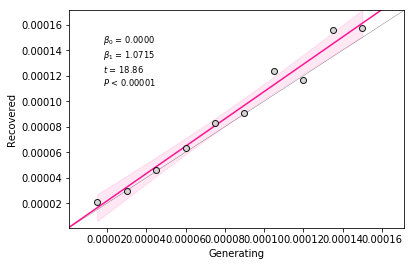

In [10]:
# Example of a plot of a single recovery panel
# specify other (background) parameters levels
other_levels = dict(tau='high', s='medium', gamma='low')
ax = plot_recovery_panel(recovery_df, variable='v', other_levels=other_levels)

In [11]:
def plot_recovery(recovery_df,
                  variables=['v', 'gamma', 's', 'tau'],
                  levels=['low', 'medium', 'high'],
                  bounds=dict(v=[0.000015, 0.00015],
                              gamma=[-1, 1],
                              s=[0.004, 0.011],
                              tau=[0.1, 1.25])):
    """
    Plots a single axes containing the relationship between
    generating and recovered values of the indicated `variable`,
    keeping all other parameters at their respective levels
    specified in the `other_levels` dictionary.
    """
    from itertools import product
    
    n_rows = len(variables)
    n_cols = (len(levels))**(len(variables)-1)
    
    fig, axs = plt.subplots(n_rows, n_cols,
                            figsize=(n_cols*3, n_rows*3),
                            sharey='row',
                            sharex='row')

    for i, var in enumerate(variables):
        others = [v for v in variables
                  if v != var]
        n_others = len(others)
        
        if n_others == 1:            
            constellations = list(product(levels))
        elif n_others == 2:
            constellations = list(product(levels, levels))
        elif n_others == 3:
            constellations = list(product(levels, levels, levels))
        else:
            ValueError('What?!')

        for j, constellation in enumerate(constellations):
            other_levels = {other: constellation[o]
                            for o, other in enumerate(others)}
            try: 
                axs[i, j] = plot_recovery_panel(recovery_df, variable=var, other_levels=other_levels, ax=axs[i, j])
            except:
                continue
            axs[i, j].set_title('')
            axs[i, j].set_xlabel('')
            axs[i, j].set_ylabel('')
            title = ['{}: {}, '.format(other, level)
                     for other, level in other_levels.items()]
            axs[i, j].set_title(''.join(title))
            axs[i, j].set_xlim(*bounds[var])
            axs[i, j].set_ylim(*bounds[var])
            
        axs[i, 0].set_ylabel('{}\nRecovered'.format(var))
    
    for ax in axs[-1, :]:
        ax.set_xlabel('Generating')
    
    fig.tight_layout()
    
    return fig, axs

In [12]:
recovery_df = pd.read_csv('/Users/felixmolter/Dropbox/recovery_partial.csv')
print('P(converged):', recovery_df['converged'].mean())
recovery_df = recovery_df[recovery_df['converged'] == True].copy()

P(converged): 0.718296224589


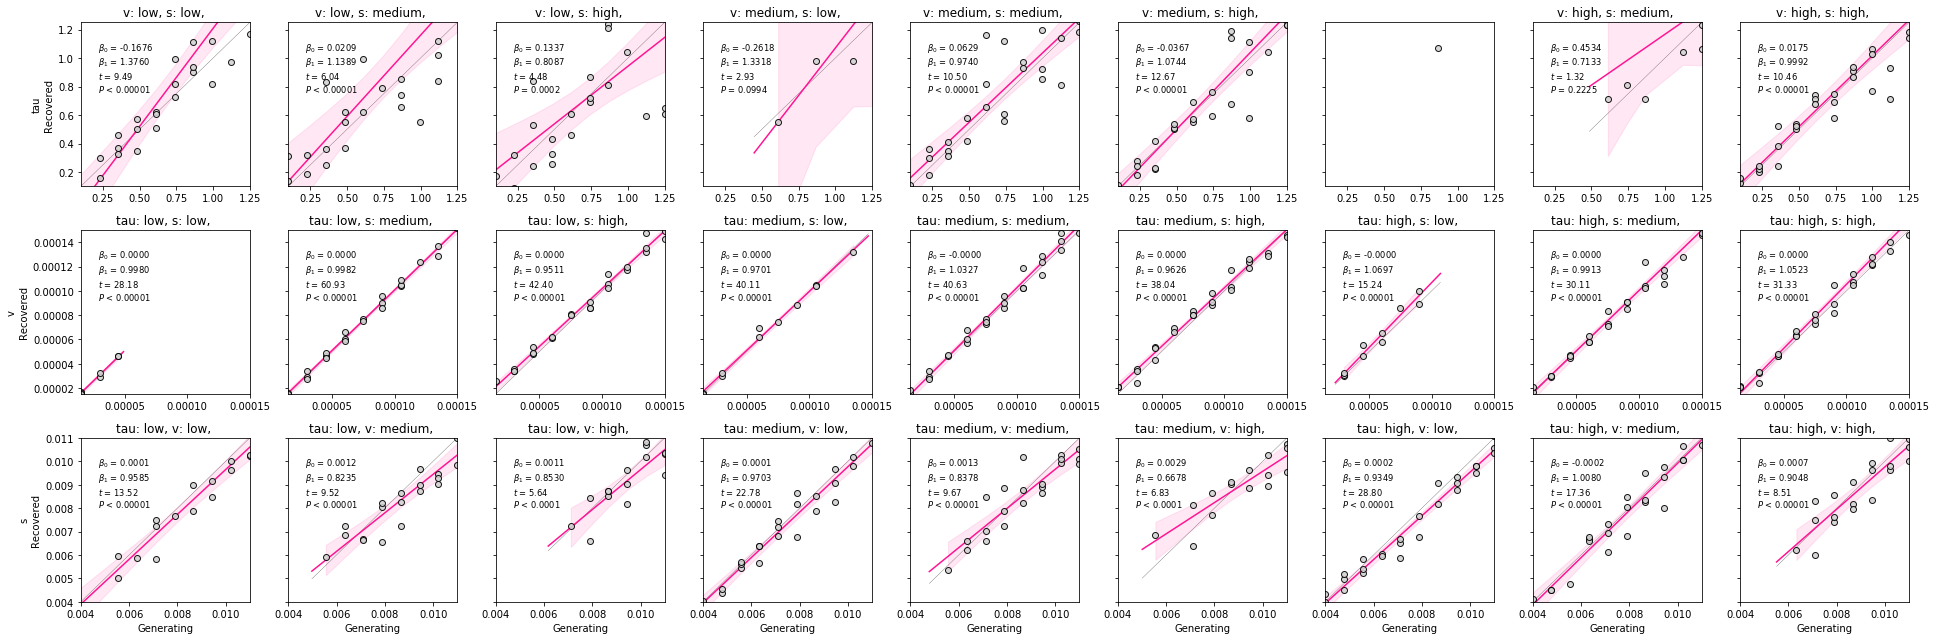

In [15]:
plot_recovery(recovery_df=recovery_df, variables=['tau', 'v', 's']);
plt.savefig('/Users/felixmolter/Desktop/recovery_converged_3.png', dpi=300)